In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
import h5py
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import entr
from drift_ml.datasets.bosch_cnc_machining.utils.utils import augment_xyz_samples
from drift_ml.datasets.bosch_cnc_machining.utils.dataloader import RawBoschCNCDataloader, STFTBoschCNCDataloader, NPYBoschCNCDataLoader

In [30]:
base_loader = NPYBoschCNCDataLoader(metadata_path="/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/metadata_ws4096.pkl")
base_loader.load_data(
    sample_data_x_path="/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/npy/sample_data_x_raw_ws4096.npy",
    sample_data_y_path="/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/npy/sample_data_y_raw_ws4096.npy"
    )
base_loader.generate_datasets_by_size(train_size=.4,val_size=.2,test_size=.4)

In [31]:
stft_base_loader = base_loader.get_windowed_samples_as_stft_dataloader(transform_fn=lambda x: x)
X_train_base, X_val_base, X_test_base = stft_base_loader.get_standardized_train_val_test()

  0%|          | 0/42978 [00:00<?, ?it/s]

In [62]:
from torch import tensor
from drift_ml.datasets.bosch_cnc_machining.utils.evaluation import Metrics
from drift_ml.datasets.bosch_cnc_machining.models.nnclassifier import NNEnsembleClassifier

metric_calculator = Metrics()
ensemble = NNEnsembleClassifier(n_ensemble=5)

In [64]:
ensemble.fit(
    fit_args=[
        X_train_base, 
        stft_base_loader.y_train[:, np.newaxis], 
        X_val_base, 
        stft_base_loader.y_val[:, np.newaxis]
    ],
    fit_kwargs={
        "lrate": 1e-2,
        "epochs": 20
    }
)

/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/models/nnclassifier.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor(X).to(self.device).float(),
/home/tbiegel/nico_files/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/models/nnclassifier.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor(X).to(self.device).float(),
DEBUG:root:Final val. performance: AUROC 0.97, AURPC 0.92, F1 0.87
DEBUG:root:Final val. performance: AUROC 0.97, AURPC 0.92, F1 0.86
DEBUG:root:Final val. performance: AUROC 0.98, AURPC 0.96, F1 0.93
DEBUG:root:Final val. performance: AUROC 0.97, AURPC 0.95, F1 0.94
DEBUG:root:Final val. performance: AUROC 0.98, AURPC 0.96, F

In [71]:
y_base, y_base_scores = ensemble.predict(X_test_base, return_scores=True)

base_entropies = entr(y_base_scores)
metric_calculator.print(y_base_scores, stft_base_loader.y_test[:, np.newaxis])

   BinaryAUROC  BinaryAveragePrecision  BinaryF1Score  BinaryMatthewsCorrCoef
0      0.90538                0.821183       0.842105                0.844149


In [66]:
shift = 40

print(f"Evaluating {shift} degrees pitch shift")
stft_loader = base_loader.get_windowed_samples_as_stft_dataloader(
    transform_fn=lambda x: augment_xyz_samples(x, pitch_deg=shift, yaw_deg=shift)
)
X_test_shift = stft_base_loader.standardize_datasets([stft_loader.X_test])[0]

Evaluating 40 degrees pitch shift


  0%|          | 0/42978 [00:00<?, ?it/s]

In [73]:
y_shift, y_shift_scores = ensemble.predict(X_test_shift, return_scores=True)

shift_entropies = entr(y_shift_scores)
avg_entropy = np.mean(shift_entropies)

metric_calculator.print(y_shift_scores, stft_loader.y_test[:, np.newaxis])

   BinaryAUROC  BinaryAveragePrecision  BinaryF1Score  BinaryMatthewsCorrCoef
0     0.900785                0.705589       0.594093                0.583093


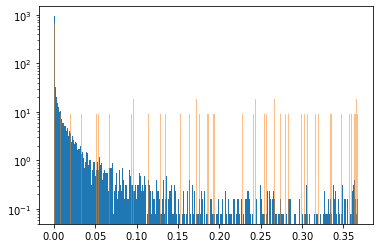

In [77]:
plt.hist(base_entropies[stft_base_loader.y_test[:, np.newaxis] == y_base], log=True, density=True, bins=500)
plt.hist(base_entropies[stft_base_loader.y_test[:, np.newaxis] != y_base], log=True, density=True, bins=500, alpha=0.5)
plt.show()

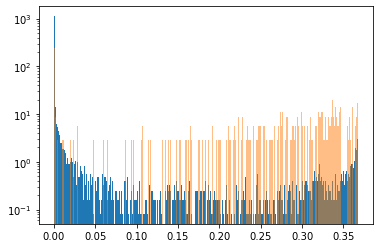

In [78]:
plt.hist(shift_entropies[stft_loader.y_test[:, np.newaxis] == y_shift], log=True, density=True, bins=500)
plt.hist(shift_entropies[stft_loader.y_test[:, np.newaxis] != y_shift], log=True, density=True, bins=500, alpha=0.5)
plt.show()

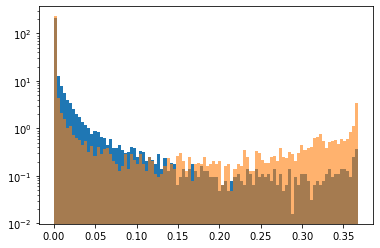

In [98]:
plt.hist(base_entropies, log=True, density=True, bins=100)
plt.hist(shift_entropies, log=True, density=True, bins=100, alpha=0.6)
plt.show()

In [83]:
import seaborn as sns